In [1]:
!pip install fastai
!pip install boto3
!pip install tqdm
!pip install timm
!pip install wandb
!pip install split-folders
!pip install gdown --upgrade
!pip install fastai==2.5.2 fastcore==1.3.26
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [1]:
from PIL import Image
import os

In [2]:
from fastai.vision.all import *
import timm
#from fastai.distributed import *
import warnings
warnings.simplefilter("ignore")

In [3]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

random_seed(42, True)

In [4]:
def create_cls_module(nf, n_out, lin_ftrs=None, ps=0.5, use_bn=False, first_bn=False, bn_final=False, lin_first=False, y_range=None):
    "Creates classification layer which takes nf flatten features and outputs n_out logits"
    lin_ftrs = [nf, 512, n_out] if lin_ftrs is None else [nf] + lin_ftrs + [n_out]
    bns = [first_bn] + [use_bn]*len(lin_ftrs[1:])
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = []
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,bn,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], bns, ps, actns):
        layers += LinBnDrop(ni, no, bn=bn, p=p, act=actn, lin_first=lin_first)
    if lin_first: layers.append(nn.Linear(lin_ftrs[-2], n_out))
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    if y_range is not None: layers.append(SigmoidRange(*y_range))
    return nn.Sequential(*layers)

In [5]:
path = r'C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/RSI-CB256_splitted'
bs = 16
sz = 224

data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y= parent_label,
    splitter= GrandparentSplitter(train_name = "train",valid_name = "val"))#,
    #item_tfms=Resize(460),
    #batch_tfms=aug_transforms(mult=1.0, do_flip=True, flip_vert=True, max_rotate=120.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=64, mode='bilinear', pad_mode='reflection', align_corners=True, batch=False, min_scale=1.0))

In [6]:
dls = data.dataloaders(path, bs=bs)
print("Number of classes: ",dls.c)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Number of classes:  35


In [14]:
arch = "swin_base_patch4_window7_224_in22k"
model = timm.create_model(arch, pretrained=True, in_chans=3, num_classes=0)

In [16]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      dim=128, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
     

In [15]:
len(dict(model.named_modules()))

410

In [19]:
model.fc = nn.Sequential(create_cls_module(nf=model.num_features, n_out=dls.c))

In [20]:
savedfilename = f'{path}_{arch}'
learn = Learner(dls, model, metrics=[accuracy,Precision(average='macro'), Recall(average='macro'), F1Score(average='macro')],  cbs=[CSVLogger(fname=savedfilename+'.csv', append=True),
                         SaveModelCallback(monitor='valid_loss', comp=None, min_delta=0.0,fname=savedfilename, every_epoch=False, with_opt=False, reset_on_fit=True)])#.to_fp16()

In [21]:
learn.summary()

ResNet (Input shape: 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 128 x 128 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 256 x 64 x 64  
Conv2d                                    16384      True      
BatchNorm2d                               512 

SuggestedLRs(valley=0.0004786300996784121)

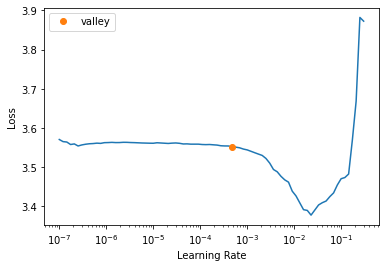

In [22]:
lr = learn.lr_find()

In [ ]:
learn.fit(20,lr)

In [19]:
timm.list_models("swin*",pretrained=True)

['swin_base_patch4_window7_224',
 'swin_base_patch4_window7_224_in22k',
 'swin_base_patch4_window12_384',
 'swin_base_patch4_window12_384_in22k',
 'swin_large_patch4_window7_224',
 'swin_large_patch4_window7_224_in22k',
 'swin_large_patch4_window12_384',
 'swin_large_patch4_window12_384_in22k',
 'swin_small_patch4_window7_224',
 'swin_tiny_patch4_window7_224']

In [14]:
timm.list_models("convnext*",pretrained=True)

['convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']